In [1]:
import itertools
import pandas as pd
import geopandas as gpd
import areal_interpolation as ai
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
import numpy as np
%load_ext autoreload
%autoreload 2

We're going to test out different methods for aggregating data from one map to another. We're not going to use anything too fancy; these methods have been around since at least the 80s ([Lam, 1983. Spatial Interpolation Methods: A Review](https://www.colorado.edu/geography/leyk/geog_4203/readings/Lam_1983_Interpolation_Review_CaGIS.pdf)). The idea is to take a "source" map that contains some data of interest, and aggregate it up to a "target" map.

In this case, our source map is 2016 PA Voter Tabulation Districts from Nathaniel Kelso and Michal Migurski's [repository](https://github.com/nvkelso/election-geodata/tree/master/data/42-pennsylvania/statewide/2017), and our target map is the remedial Congressional map adopted by the PA Supreme Court for the 2018 elections ([Public Interest Law Center](https://www.pubintlaw.org/cases-and-projects/pa-supreme-court-adopts-new-congressional-map/))

Let's load the data and take a peek.

In [3]:
CDs = gpd.read_file('data/Remedial Plan Shapefile.shp')

VTDs = gpd.read_file('data/VTDs_Oct17.shp')
VTDs.to_crs(CDs.crs)  # match projections. not sure this is necessary
VTDs.head()

,OBJECTID_1,OBJECTID,NAMELSAD,CORRECTSTF,TAPERSONS,TA1RACE,TAWHITEALN,TABLACKALN,TAAMINDALN,TAASIANALN,...,T16AUDR,T16TREASD,T16TREASR,T16CONGD,T16CONGR,T16STSD,T16STSR,T16STHD,T16STHR,geometry
0,0,0,SEVEN SPRINGS,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,POLYGON ((-79.29631599978353 40.03651399962142...
1,0,0,ASHLAND,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,POLYGON ((-76.36467799988975 40.78114699973429...
2,3,3,RICHLAND TWP Voting District-Psudo (Emlenton B...,420310400-P1,8,8,8,0,0,0,...,0,0,0,0,0,0,0,0,0,(POLYGON ((-79.69325499991828 41.1830559997346...
3,4,4,ALLEGHENY TWP DIST 04 - Psudo (Tunnelhill Boro...,420130040-P1,118,118,114,0,0,4,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-78.5420060003766 40.46965299998601,..."
4,5,5,WEST SADSBURY TWP Voting District,420291740,2444,2414,2247,123,2,10,...,540,326,532,289,622,354,568,0,707,POLYGON ((-75.93793200026157 40.00866899977456...


In [4]:
CDs.head()

,geometry
0,"POLYGON ((-75.48405700000001 40.418451, -75.47..."
1,"POLYGON ((-74.980688 40.065007, -74.9807019999..."
2,"POLYGON ((-75.206968 40.011372, -75.206914 40...."
3,"POLYGON ((-75.48405700000001 40.418451, -75.48..."
4,"POLYGON ((-75.502135 39.954367, -75.501051 39...."


In [5]:
VTDs.head().iloc[:, [1,2,3,-1]]

,OBJECTID,NAMELSAD,CORRECTSTF,geometry
0,0,SEVEN SPRINGS,None,POLYGON ((-79.29631599978353 40.03651399962142...
1,0,ASHLAND,None,POLYGON ((-76.36467799988975 40.78114699973429...
2,3,RICHLAND TWP Voting District-Psudo (Emlenton B...,420310400-P1,(POLYGON ((-79.69325499991828 41.1830559997346...
3,4,ALLEGHENY TWP DIST 04 - Psudo (Tunnelhill Boro...,420130040-P1,"POLYGON ((-78.5420060003766 40.46965299998601,..."
4,5,WEST SADSBURY TWP Voting District,420291740,POLYGON ((-75.93793200026157 40.00866899977456...


Let's plot the two maps.

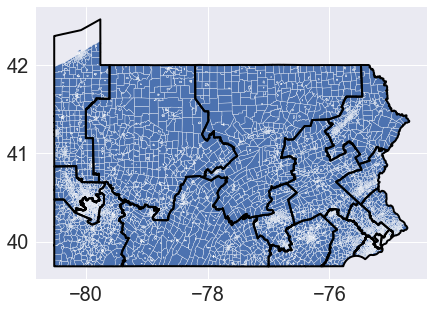

In [16]:
fig, ax = plt.subplots(1, figsize=(7,5))
VTDs.plot(ax=ax, edgecolor='white')
CDs.plot(ax=ax, edgecolor='black', color='none', lw=2)

Now let's move the source data to the target map. We'll take the 2016 Presidential D and R precinct-level votes (column names `T16PRESD` and `T16PRESR` and total them up for each district.

In [7]:
vote_columns = ['T16PRESD', 'T16PRESR']

VTDs_out, CDs_out = ai.aggregate(VTDs, CDs, vote_columns)

Taking a look at our new tables, we can see that the `CDs_out` table has new columns for the total vote count.

The `VTDs_out` table has a `target_index` indicating which congressional district it is contained in.

In [8]:
CDs_out.head()

,T16PRESD,T16PRESR,geometry
0,189263,181638,"POLYGON ((-75.48405700000001 40.418451, -75.47..."
1,207259,70703.9,"POLYGON ((-74.980688 40.065007, -74.9807019999..."
2,339424,26174.9,"POLYGON ((-75.206968 40.011372, -75.206914 40...."
3,221289,147348,"POLYGON ((-75.48405700000001 40.418451, -75.48..."
4,230155,126402,"POLYGON ((-75.502135 39.954367, -75.501051 39...."


In [9]:
VTDs_out.head().iloc[:, [1,2,3,-2,-1]]

,OBJECTID,NAMELSAD,CORRECTSTF,geometry,target_index
0,0,SEVEN SPRINGS,None,POLYGON ((-79.29631599978353 40.03651399962142...,11.0
1,0,ASHLAND,None,POLYGON ((-76.36467799988975 40.78114699973429...,17.0
2,3,RICHLAND TWP Voting District-Psudo (Emlenton B...,420310400-P1,(POLYGON ((-79.69325499991828 41.1830559997346...,12.0
3,4,ALLEGHENY TWP DIST 04 - Psudo (Tunnelhill Boro...,420130040-P1,"POLYGON ((-78.5420060003766 40.46965299998601,...",10.0
4,5,WEST SADSBURY TWP Voting District,420291740,POLYGON ((-75.93793200026157 40.00866899977456...,5.0


There are a few different ways to do this aggregation, which potentially trade off speed and accuracy:
- 'fractional_area': Assumes that the data is distributed uniformly within each source shape and distributes the data by the proportion of the source shape that lies in each target shape. The slowest, but probably the most accurate method in most cases.

- 'greatest_area': Recommended if source shapes should never intersect with more than one target shape. About 1.5x faster than 'fractional_area'. Works like 'fractional_area', but assigns all of the data from the source shapes to target shapes in a winner-take-all fashion, with the target shape with the greatest proportion of a source shape taking all the data.

- 'first_centroid': Like 'greatest_area', assigns data in a winner-take-all fashion based on the first target shape found to contain the centroid of a source shape. About 2x faster than 'greatest_area' and 3x faster than 'fractional_area'. Might have trouble with funny shapes.

All three methods should perform about equally well in our case, because our VTD (source) shapes aren't very unusual, and because VTDs are for the most part wholly contained in one district. Let's first confirm that the assignments of Congressional districts seems right.

In [10]:
methods = ['fractional_area', 'greatest_area', 'first_centroid']

VTDs_out = {}
CDs_out = {}

for m in methods:
    VTDs_out[m], CDs_out[m] = ai.aggregate(VTDs, CDs, vote_columns, method=m)

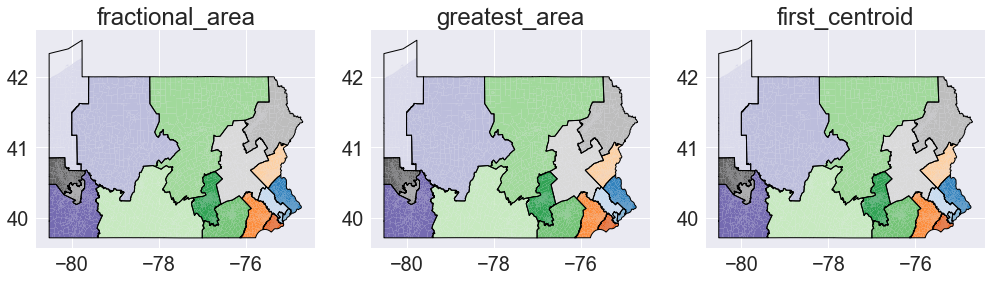

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,4))
for i, m in enumerate(methods):
    VTDs_out[m].plot(ax=ax[i], edgecolor='none', column='target_index', cmap='tab20c')
    CDs_out[m].plot(ax=ax[i], edgecolor='black', color='none', lw=1)
    ax[i].set_title(m)

All three methods look good from a bird's eye view. Now let's confirm that they are assigning similar vote totals to each district.

In [12]:
pd.concat([pd.DataFrame(CDs_out[m]['T16PRESD']).rename(columns={'T16PRESD': 'T16PRESD, ' + m}) for m in methods], axis=1)

,"T16PRESD, fractional_area","T16PRESD, greatest_area","T16PRESD, first_centroid"
0,189263,189444,189444
1,207259,207182,207182
2,339424,339662,339662
3,221289,221342,221342
4,230155,229722,229722
5,185762,185691,185691
6,160189,160137,160137
7,149876,149671,149671
8,115297,115255,115255
9,91088,91214,91214


That looks good too.

Now let's compare the speed of the various methods. We also want to confirm that using an [R-tree](https://en.wikipedia.org/wiki/R-tree) spatial index (which we do by default) actually speeds things up.

In [14]:
parameters = {'method': ['fractional_area', 'greatest_area', 'first_centroid'],
              'spatial_index': [True, False],
              'N': np.logspace(2,np.log10(9152),6).astype(int)}
keys = list(parameters)

df = pd.DataFrame(columns=keys + ['t'])

for values in itertools.product(*map(parameters.get, keys)):
    params = dict(zip(keys, values))
    N = params.pop('N')
    x = %timeit -q -o -r 1 ai.aggregate(VTDs.iloc[:N], CDs, vote_columns, **params)
    params['t'] = x.best
    params['N'] = N
    df = df.append(params, ignore_index=True)

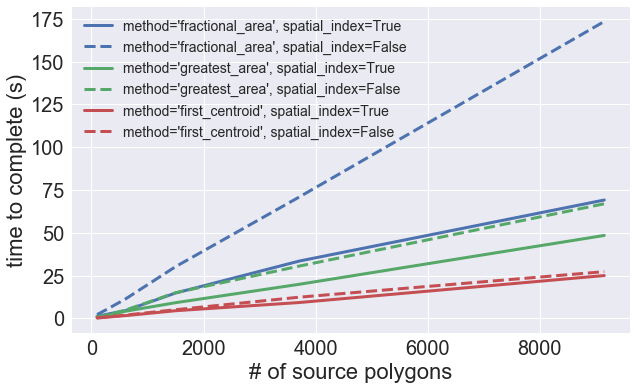

In [20]:
colors = ['C0', 'C1', 'C2']
fig, ax = plt.subplots(1,1,figsize=(10,6))
for i, m in enumerate(parameters['method']):
    for s in parameters['spatial_index']:
        x = df[(df['method']==m) & (df['spatial_index']==s)]
        if s:
            line = '-'
        else:
            line = '--'
        plt.plot(x['N'], x['t'],
                 line,
                 color=colors[i],
                 label="method='{}', spatial_index={}".format(m, s),
                 lw=3)
        plt.legend(fontsize=14)
plt.xlabel('# of source polygons')
plt.ylabel('time to complete (s)');


To conclude, the fractional_area method is probably the right option in general. If it takes too long and you are confident that target shapes don't split source shapes, you can probably switch to one of the faster methods without a major hit on accuracy.